# Stanford Car Classifier Model
Model is built with fastai v1 and PyTorch v1, trained on Google Cloud Platform's Deep Learning
Data Consist of 8144 Training Images

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Import Libraries
from fastai.vision import *
from fastai.metrics import error_rate
from scipy.io import loadmat
import pandas as pd

# Data Preparation

## Download data from stanford.edu

In [3]:
#url = "http://imagenet.stanford.edu/internal/car196/cars_train"
#url_label = "https://ai.stanford.edu/~jkrause/cars/car_devkit"
car_path = Path('/home/jupyter/.fastai/data/car')

# path = untar_data(url);
# path_label = untar_data(url_label); path_label

car_train = Path(car_path/'cars_train');
car_test  = Path(car_path/'cars_test');
car_label = Path(car_path/'devkit');

In [4]:
## Training Data Cleaning
mat_data = loadmat(car_label/'cars_train_annos.mat')
mat_meta = loadmat(car_label/'cars_meta.mat')

In [5]:
mat_meta

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 '__globals__': [],
 'class_names': array([[array(['AM General Hummer SUV 2000'], dtype='<U26'), array(['Acura RL Sedan 2012'], dtype='<U19'),
         array(['Acura TL Sedan 2012'], dtype='<U19'), array(['Acura TL Type-S 2008'], dtype='<U20'), ...,
         array(['Volvo C30 Hatchback 2012'], dtype='<U24'), array(['Volvo 240 Sedan 1993'], dtype='<U20'),
         array(['Volvo XC90 SUV 2007'], dtype='<U19'), array(['smart fortwo Convertible 2012'], dtype='<U29')]],
       dtype=object)}

In [6]:
class_id_label = mat_data['annotations']["class"].squeeze(); class_id_label

array([array([[14]], dtype=uint8), array([[3]], dtype=uint8), array([[91]], dtype=uint8), array([[134]], dtype=uint8),
       ..., array([[196]], dtype=uint8), array([[163]], dtype=uint8), array([[112]], dtype=uint8),
       array([[17]], dtype=uint8)], dtype=object)

In [7]:
fname = mat_data['annotations']['fname'].squeeze(); fname

array([array(['00001.jpg'], dtype='<U9'), array(['00002.jpg'], dtype='<U9'), array(['00003.jpg'], dtype='<U9'),
       array(['00004.jpg'], dtype='<U9'), ..., array(['08141.jpg'], dtype='<U9'), array(['08142.jpg'], dtype='<U9'),
       array(['08143.jpg'], dtype='<U9'), array(['08144.jpg'], dtype='<U9')], dtype=object)

In [8]:
class_names = mat_meta['class_names'].squeeze(); class_names

array([array(['AM General Hummer SUV 2000'], dtype='<U26'), array(['Acura RL Sedan 2012'], dtype='<U19'),
       array(['Acura TL Sedan 2012'], dtype='<U19'), array(['Acura TL Type-S 2008'], dtype='<U20'), ...,
       array(['Volvo C30 Hatchback 2012'], dtype='<U24'), array(['Volvo 240 Sedan 1993'], dtype='<U20'),
       array(['Volvo XC90 SUV 2007'], dtype='<U19'), array(['smart fortwo Convertible 2012'], dtype='<U29')],
      dtype=object)

In [9]:
class_id_label_list = [class_id[0][0] for class_id in class_id_label]; class_id_label_list[:5]

[14, 3, 91, 134, 106]

In [10]:
fname_list = [f[0] for f in fname]; fname_list[:5]

['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg']

In [11]:
class_names_list = [c[0] for c in class_names]; class_names_list[:5]

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012']

In [12]:
#Mapping id to classnames for verboseness
class_name_label_list = [class_names_list[idx-1] for idx in class_id_label_list]; class_name_label_list[:5]

['Audi TTS Coupe 2012',
 'Acura TL Sedan 2012',
 'Dodge Dakota Club Cab 2007',
 'Hyundai Sonata Hybrid Sedan 2012',
 'Ford F-450 Super Duty Crew Cab 2012']

In [13]:
train_df = pd.DataFrame(
            {'fname': fname_list,
             'label': class_name_label_list,
            })

In [14]:
train_df.head()

,fname,label
0,00001.jpg,Audi TTS Coupe 2012
1,00002.jpg,Acura TL Sedan 2012
2,00003.jpg,Dodge Dakota Club Cab 2007
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012


## Preparing Test Data

In [15]:
car_path

PosixPath('/home/jupyter/.fastai/data/car')

In [16]:
#Download the data from source
#test_path = untar_data("http://imagenet.stanford.edu/internal/car196/cars_test")
#test_mat_path = Path(car_path/'devkit/cars_test_annos.mat')

test_path = Path(car_label/'cars_test')
test_mat_path = Path(car_path/'cars_test_annos_withlabels.mat')


In [17]:
test_mat_path

PosixPath('/home/jupyter/.fastai/data/car/cars_test_annos_withlabels.mat')

In [18]:
#mat_test = loadmat(path_label/'cars_test_annos.mat');mat_test
mat_test_label = loadmat(test_mat_path)

In [19]:
mat_test_label

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([[(array([[30]], dtype=uint8), array([[52]], dtype=uint8), array([[246]], dtype=uint8), array([[147]], dtype=uint8), array([[181]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
         (array([[100]], dtype=uint8), array([[19]], dtype=uint8), array([[576]], dtype=uint16), array([[203]], dtype=uint8), array([[103]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
         (array([[51]], dtype=uint8), array([[105]], dtype=uint8), array([[968]], dtype=uint16), array([[659]], dtype=uint16), array([[145]], dtype=uint8), array(['00003.jpg'], dtype='<U9')),
         (array([[67]], dtype=uint8), array([[84]], dtype=uint8), array([[581]], dtype=uint16), array([[407]], dtype=uint16), array([[187]], dtype=uint8), array(['00004.jpg'], dtype='<U9')),
         ...,
         (array([[23]], dtype=uint8), array([[18]], dtype=uint8), arr

In [20]:
test_id_label = mat_test_label['annotations']['class'].squeeze();test_id_label

array([array([[181]], dtype=uint8), array([[103]], dtype=uint8), array([[145]], dtype=uint8),
       array([[187]], dtype=uint8), ..., array([[16]], dtype=uint8), array([[17]], dtype=uint8),
       array([[38]], dtype=uint8), array([[32]], dtype=uint8)], dtype=object)

In [21]:
test_fname = mat_test_label['annotations']['fname'].squeeze(); test_fname

array([array(['00001.jpg'], dtype='<U9'), array(['00002.jpg'], dtype='<U9'), array(['00003.jpg'], dtype='<U9'),
       array(['00004.jpg'], dtype='<U9'), ..., array(['08038.jpg'], dtype='<U9'), array(['08039.jpg'], dtype='<U9'),
       array(['08040.jpg'], dtype='<U9'), array(['08041.jpg'], dtype='<U9')], dtype=object)

In [22]:
test_id_label_list = [class_id[0][0] for class_id in test_id_label]
test_fname_list = [f[0] for f in test_fname] 
class_names_list;

# Mapping id to classnames for verboseness
test_class_name_label_list = [class_names_list[idx-1] for idx in test_id_label_list] 

test_df = pd.DataFrame(
    {'fname': test_fname_list,
     'label': test_class_name_label_list,
    })


In [23]:
test_df.head()

,fname,label
0,00001.jpg,Suzuki Aerio Sedan 2007
1,00002.jpg,Ferrari 458 Italia Convertible 2012
2,00003.jpg,Jeep Patriot SUV 2012
3,00004.jpg,Toyota Camry Sedan 2012
4,00005.jpg,Tesla Model S Sedan 2012


#Transform

In [24]:
#Transformation for Data Augmentation
arch = models.resnet34
arch_name = 'resnet34'
metric = [accuracy]
tfms = get_transforms()
size = 299
bs = 16

In [25]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

In [26]:
data = (
    ImageList.from_df(df=train_df, path=car_train)
    .split_by_rand_pct(valid_pct=.2, seed=1010)
    .label_from_df(cols='label')
    .transform(tfms=tfms, size=size)
    .databunch(bs=bs)
)

In [27]:
data

ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: /home/jupyter/.fastai/data/car/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Nissan 240SX Coupe 1998,Audi S5 Convertible 2012,Chevrolet Sonic Sedan 2012,Chevrolet Silverado 1500 Hybrid Crew Cab 2012,Mercedes-Benz S-Class Sedan 2012
Path: /home/jupyter/.fastai/data/car/cars_train;

Test: None

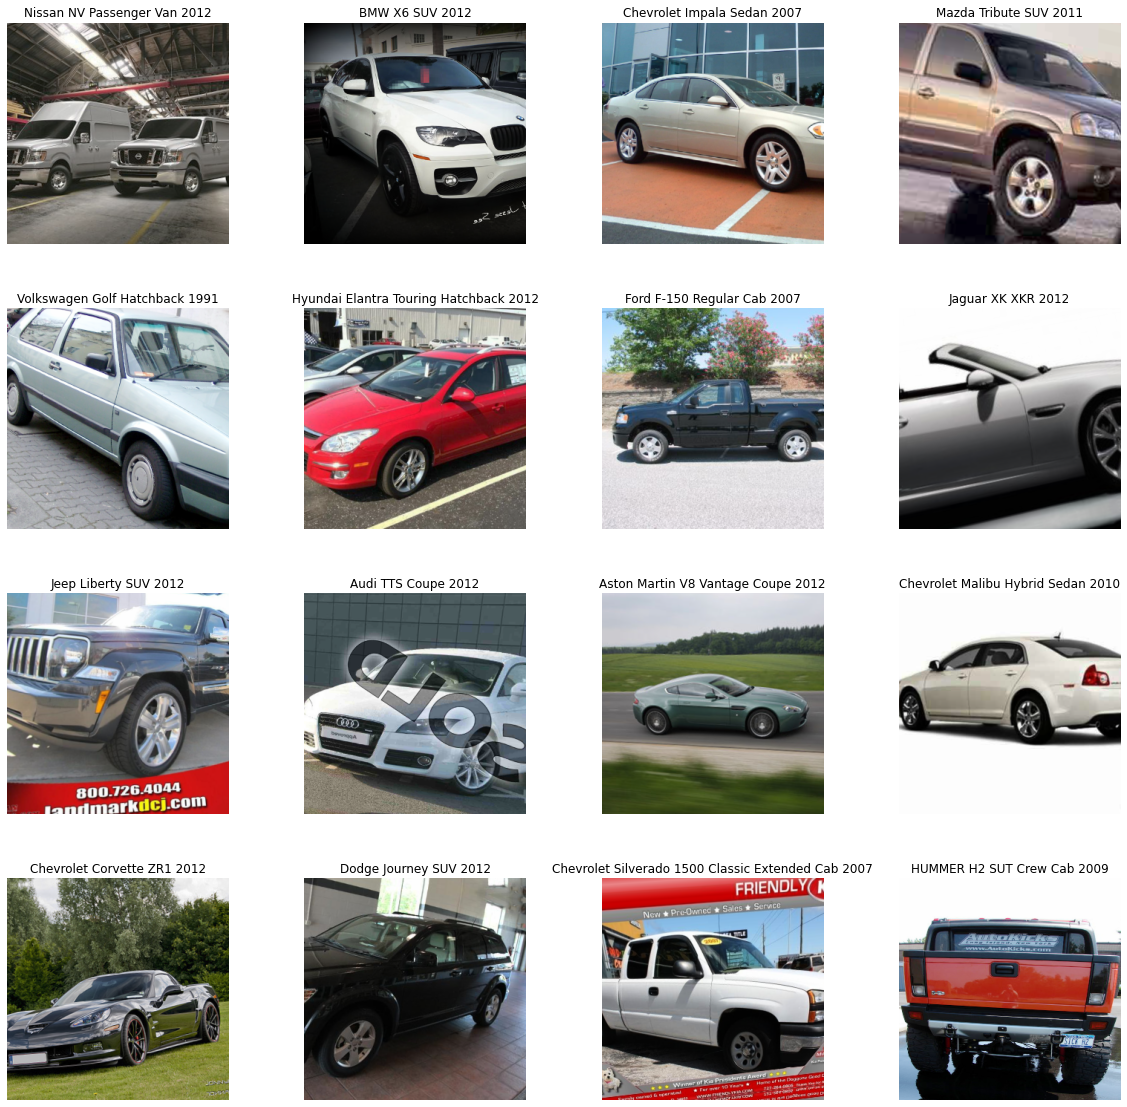

In [28]:
data.show_batch()

concanteaning traing and testing dataframes

In [29]:
df1 = train_df
train_df['is_valid'] = False
df2 = test_df
test_df['is_valid'] = True
full_df = pd.concat([df1,df2])

In [30]:
full_df.head()

,fname,label,is_valid
0,00001.jpg,Audi TTS Coupe 2012,False
1,00002.jpg,Acura TL Sedan 2012,False
2,00003.jpg,Dodge Dakota Club Cab 2007,False
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,False
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,False


preparing test databunch

In [31]:
test_data = (ImageList.from_df(df=full_df, path=car_test)
            .split_from_df()
            .label_from_df(cols='label')
            .transform(tfms=tfms, size=size)
            .databunch(bs=bs)
            )

In [32]:
test_data

ImageDataBunch;

Train: LabelList (8144 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: /home/jupyter/.fastai/data/car/cars_test;

Valid: LabelList (8041 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Suzuki Aerio Sedan 2007,Ferrari 458 Italia Convertible 2012,Jeep Patriot SUV 2012,Toyota Camry Sedan 2012,Tesla Model S Sedan 2012
Path: /home/jupyter/.fastai/data/car/cars_test;

Test: None

In [33]:
learn = cnn_learner(data, arch, metrics=metric)

In [34]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 75]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
ReLU                 [64, 75, 75]         0          False     
___________________________________________________

In [35]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


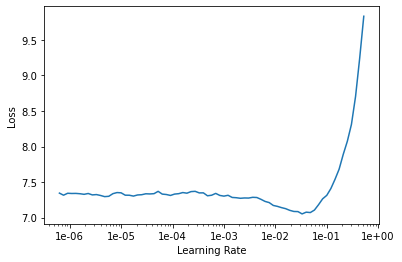

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(10, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,6.625727,5.233017,0.027027,00:53
1,5.018857,3.889999,0.154177,00:52
2,3.857175,3.079838,0.274570,00:53
3,3.237139,2.583752,0.381450,00:52
4,2.787497,2.285373,0.441032,00:52
5,2.463183,2.053958,0.473587,00:52
6,2.132838,1.893291,0.515356,00:52
7,1.947867,1.818918,0.545455,00:52


In [38]:
learn.save('car-'+ arch_name +'-299px-5ep-1e-3')

In [39]:
learn.validate(test_data.valid_dl)

[1.8087448, tensor(0.5457)]

In [40]:
learn.unfreeze()

In [41]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


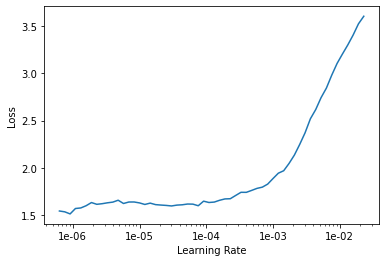

In [42]:
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(10, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.677947,1.683768,0.578624,00:54
1,1.744826,1.488974,0.624693,00:53
2,1.526219,1.306098,0.660319,00:53
3,1.367600,1.138418,0.698403,00:52
4,1.139444,1.045387,0.719902,00:53
5,0.840413,0.909875,0.757985,00:53
6,0.621223,0.823108,0.766585,00:54
7,0.491785,0.783869,0.776413,00:54
8,0.402954,0.745410,0.792383,00:52


In [44]:
learn.save('car-'+ arch_name +'-299-unfreeze-5ep-1e6-1e3')

In [45]:
learn.validate(test_data.valid_dl)

[0.75718814, tensor(0.7934)]

## Add normalize imagenet stats

In [46]:
data_normalize = (
    ImageList.from_df(df=train_df, path=car_train)
    .split_by_rand_pct(valid_pct=.2, seed=1010)
    .label_from_df(cols='label')
    .transform(tfms=tfms, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

In [47]:
test_data = (ImageList.from_df(df=full_df, path=car_test)
            .split_from_df()
            .label_from_df(cols='label')
            .transform(tfms=tfms, size=size)
            .databunch(bs=bs)
            .normalize(imagenet_stats)
            )

In [48]:
learn_normalize = cnn_learner(data, arch, metrics=metric)

In [49]:
learn_normalize.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


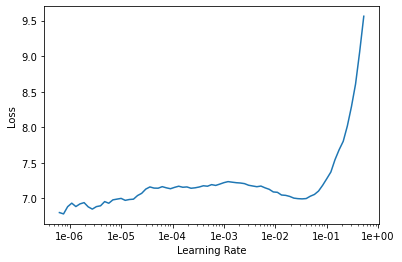

In [50]:
learn_normalize.recorder.plot()

In [51]:
learn_normalize.fit_one_cycle(10, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.565988,5.191710,0.021499,00:52
1,4.882584,3.715477,0.162776,00:51
2,3.566119,2.628049,0.372850,00:51
3,2.802433,2.057979,0.495086,00:51
4,2.396435,1.734787,0.560811,00:51
5,1.983336,1.541543,0.617936,00:51
6,1.673983,1.386805,0.646806,00:52
7,1.483096,1.294920,0.672604,00:51
8,1.388772,1.273592,0.674447,00:51


In [52]:
learn_normalize.save('car-'+ arch_name +'-normalize-299-5ep-1e-3')

In [53]:
learn_normalize.validate(test_data.valid_dl)

[12.193684, tensor(0.0076)]

In [54]:
learn_normalize.unfreeze()

In [55]:
learn_normalize.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


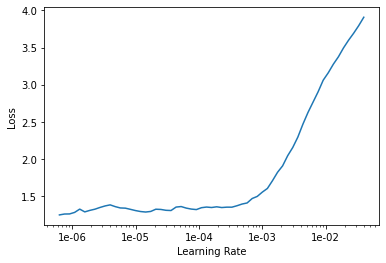

In [56]:
learn_normalize.recorder.plot()

In [57]:
learn_normalize.fit_one_cycle(10,max_lr=(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.225341,1.193228,0.694717,00:52
1,1.468287,1.254906,0.670147,00:53
2,1.429649,1.207787,0.671990,00:54
3,1.238553,1.056141,0.712531,00:56
4,0.981656,0.891006,0.758600,00:57
5,0.777447,0.756622,0.802211,00:57
6,0.587132,0.641200,0.823710,00:58
7,0.397705,0.611434,0.828010,00:57
8,0.349820,0.571129,0.841523,00:55


In [58]:
learn_normalize.validate(test_data.valid_dl)

[6.0643587, tensor(0.0485)]

In [59]:
learn_normalize.save('car-'+ arch_name +'-normalize-unfreeze-299-5ep-1e-4')

## Add resize_method=ResizeMethod.SQUISH to transform

In [61]:
data_normalize_tfms = (
    ImageList.from_df(df=train_df, path=car_train)
    .split_by_rand_pct(valid_pct=.2, seed=1010)
    .label_from_df(cols='label')
    .transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

In [62]:
learn_normalize_tfms=cnn_learner(data_normalize, arch, metrics=metric )

In [63]:
learn_normalize_tfms.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


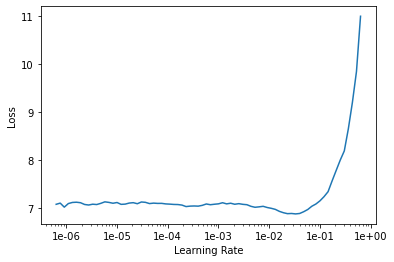

In [64]:
learn_normalize_tfms.recorder.plot()

In [65]:
learn_normalize_tfms.fit_one_cycle(10, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.561919,5.160800,0.030098,00:53
1,4.762030,3.615509,0.187961,00:54
2,3.614133,2.665797,0.356880,00:53
3,2.766013,2.057755,0.490786,00:52
4,2.325772,1.751525,0.561425,00:51
5,1.992223,1.533608,0.613636,00:51
6,1.652801,1.383318,0.650491,00:51
7,1.500519,1.294643,0.673219,00:51
8,1.349613,1.274955,0.670762,00:50


In [66]:
learn_normalize_tfms.validate(test_data.valid_dl)

[1.2422385, tensor(0.6785)]

In [67]:
learn_normalize_tfms.save('car-'+ arch_name +'-normalize-tfms-299-5ep-1e-4')

In [68]:
learn_normalize_tfms.unfreeze()

In [69]:
learn_normalize_tfms.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


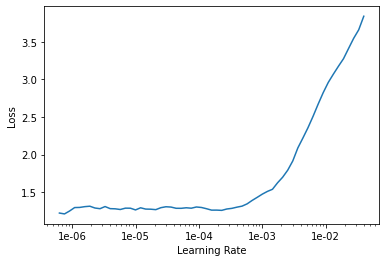

In [70]:
learn_normalize_tfms.recorder.plot()

In [71]:
learn_normalize_tfms.fit_one_cycle(10,max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.311121,1.200498,0.694717,00:52
1,1.432140,1.205049,0.686732,00:53
2,1.446147,1.171437,0.702088,00:52
3,1.198118,0.978838,0.743243,00:52
4,1.017689,0.907821,0.767813,00:52
5,0.741509,0.763829,0.786855,00:52
6,0.568012,0.662849,0.821253,00:53
7,0.416631,0.608097,0.834767,00:52
8,0.343091,0.582655,0.840909,00:53


In [72]:
learn_normalize_tfms.validate(test_data.valid_dl)

[0.55358785, tensor(0.8518)]

In [73]:
learn_normalize_tfms.save('car-'+ arch_name +'-normalize-tfms-unfreeze-299-5ep-1e-4')

## Add Mixup to learner

In [74]:
data_normalize_mixup = (
    ImageList.from_df(df=train_df, path=car_train)
    .split_by_rand_pct(valid_pct=.2, seed=1010)
    .label_from_df(cols='label')
    .transform(tfms=tfms, size=size )
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

In [75]:
learn_normalize_tfms_mixup=cnn_learner(data_normalize_mixup, arch, metrics=metric).mixup()

In [76]:
learn_normalize_tfms_mixup.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


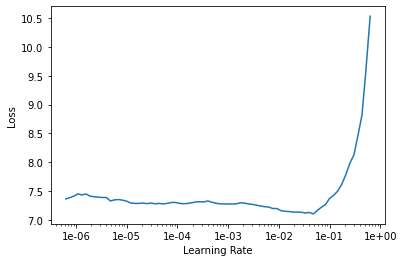

In [77]:
learn_normalize_tfms_mixup.recorder.plot()

In [78]:
learn_normalize_tfms_mixup.fit_one_cycle(10, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.700664,5.272178,0.026413,00:51
1,5.383959,3.915721,0.153563,00:50
2,4.517336,2.999550,0.300983,00:51
3,3.941459,2.433529,0.412162,00:50
4,3.526054,2.085761,0.495086,00:50
5,3.333018,1.841340,0.556511,00:50
6,3.091383,1.694330,0.585995,00:50
7,2.925790,1.605597,0.613636,00:50
8,2.853028,1.560690,0.631450,00:51


In [79]:
learn_normalize_tfms_mixup.save('car-'+ arch_name +'-normalize-mixup-299-5ep-1e-4')

In [80]:
learn_normalize_tfms_mixup.unfreeze()

In [81]:
learn_normalize_tfms_mixup.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


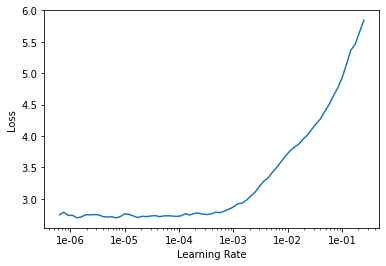

In [82]:
learn_normalize_tfms_mixup.recorder.plot()

In [83]:
learn_normalize_tfms_mixup.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.764828,1.533378,0.633292,00:52
1,2.787985,1.468925,0.649263,00:52
2,2.690216,1.393809,0.669533,00:52
3,2.628394,1.310721,0.694103,00:52
4,2.551796,1.256047,0.697789,00:52
5,2.501846,1.212704,0.707617,00:52
6,2.409986,1.175618,0.710688,00:51
7,2.319199,1.172422,0.723587,00:52
8,2.394575,1.140666,0.716830,00:52


In [84]:
learn_normalize_tfms_mixup.save('car-'+ arch_name +'-normalize-mixup-unfreeze-299-5ep-1e-4')

In [1]:
learn_normalize_tfms_mixup.validate(test_data.valid_dl)

NameError: name 'learn_normalize_tfms_mixup' is not defined